In [1]:
import numpy as np  # linear alg
import pandas as pd  # data processing 
import os
from glob import glob  # file searching
%matplotlib inline
import matplotlib.pyplot as plt  # plotting

In [2]:
# Setting up access to the images and csv

PATH = os.path.abspath('./data')
SOURCE_IMAGES = os.path.join(PATH, "images")
images = glob(os.path.join(SOURCE_IMAGES, "*.png"))
#xray_labels_df = pd.read_csv(os.path.join(PATH, 'sample_labels.csv'))
xray_labels_df = pd.read_csv(os.path.join(PATH, 'Data_Entry_2017.csv'))

In [3]:
all_image_paths = {os.path.basename(x): x for x in images}
image_names = [os.path.basename(x) for x in images]

# Removes rows from dataframe that do not have a corresponding image in the images folder.
xray_labels_df = xray_labels_df[xray_labels_df['Image Index'].isin(image_names)]

# Drop images with multiple findings 
xray_labels_df = xray_labels_df[~xray_labels_df['Finding Labels'].str.contains('\|')]
print('Number of finding labels: {}'.format(len(xray_labels_df['Finding Labels'])))

# Add the path to all images to the dataframe
xray_labels_df['path'] = xray_labels_df['Image Index'].map(all_image_paths.get)
#xray_labels_df.sample(3)
xray_labels_df.head()

Number of finding labels: 12673


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN,/Users/dennisi1/Code/school/csc665/term_projec...
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN,/Users/dennisi1/Code/school/csc665/term_projec...
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN,/Users/dennisi1/Code/school/csc665/term_projec...
5,00000003_001.png,Hernia,1,3,74,F,PA,2500,2048,0.168,0.168,NaN,/Users/dennisi1/Code/school/csc665/term_projec...
6,00000003_002.png,Hernia,2,3,75,F,PA,2048,2500,0.168,0.168,NaN,/Users/dennisi1/Code/school/csc665/term_projec...


In [4]:
xray_labels_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12673 entries, 0 to 24998
Data columns (total 13 columns):
Image Index                    12673 non-null object
Finding Labels                 12673 non-null object
Follow-up #                    12673 non-null int64
Patient ID                     12673 non-null int64
Patient Age                    12673 non-null int64
Patient Gender                 12673 non-null object
View Position                  12673 non-null object
OriginalImage[Width            12673 non-null int64
Height]                        12673 non-null int64
OriginalImagePixelSpacing[x    12673 non-null float64
y]                             12673 non-null float64
Unnamed: 11                    0 non-null float64
path                           12673 non-null object
dtypes: float64(3), int64(5), object(5)
memory usage: 1.4+ MB


In [5]:
# None of the numbers from the features are statistically interesting by themselves
xray_labels_df.describe()

,Follow-up #,Patient ID,Patient Age,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
count,12673.000000,12673.000000,12673.000000,12673.000000,12673.000000,12673.000000,12673.000000,0.0
mean,7.039770,3786.392093,47.465478,2513.970488,2359.438965,0.162162,0.162162,NaN
std,12.545309,2277.249659,16.668942,305.808207,370.102426,0.013551,0.013551,NaN
min,0.000000,1.000000,2.000000,1636.000000,1365.000000,0.115000,0.115000,NaN
25%,0.000000,1042.000000,36.000000,2500.000000,2048.000000,0.143000,0.143000,NaN
50%,2.000000,4735.000000,49.000000,2500.000000,2048.000000,0.168000,0.168000,NaN
75%,8.000000,5682.000000,59.000000,2566.000000,2544.000000,0.171000,0.171000,NaN
max,107.000000,6585.000000,94.000000,3056.000000,3056.000000,0.198800,0.198800,NaN


Preprocessing:
-------------

Findings Counts:
No Finding            8598
Infiltration          1099
Atelectasis            579
Effusion               482
Nodule                 397
Cardiomegaly           264
Mass                   246
Pneumothorax           217
Consolidation          190
Fibrosis               184
Pleural_Thickening     162
Emphysema              121
Edema                   67
Pneumonia               39
Hernia                  28
Name: Finding Labels, dtype: int64


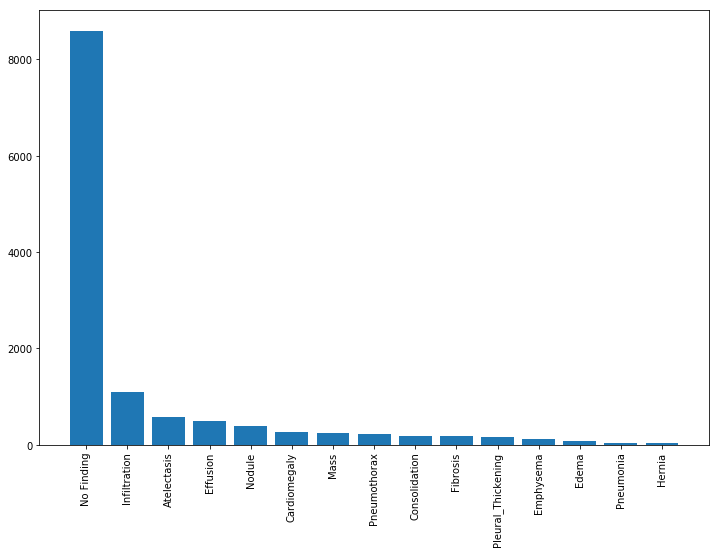

In [6]:
# Get the number of each type of disease classification
label_counts = xray_labels_df['Finding Labels'].value_counts()[:15]
print('Findings Counts:\n{}'.format(label_counts))
# plot it
fig, ax1 = plt.subplots(1, 1, figsize=(12, 8))
# Rotate and space out the labels to make them readable
ax1.bar(np.arange(len(label_counts)) + 1.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts)) + 1.5)
_ = ax1.set_xticklabels(label_counts.index, rotation=90)

'''
  We should drop diagnosises with poor data set representation
  Those cases will probably train badly (based on the NIH paper)
'''

In [7]:
from itertools import chain

# Replace Finding Labels with no finding to be blank
xray_labels_df['Finding Labels'] = xray_labels_df['Finding Labels'].map(lambda x: x.replace('No Finding', ''))

# Add columns to for each diagnosis to df
all_labels = np.unique(list(chain(*xray_labels_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x) > 0]

# Adds attributes for each possible finding, and assigns value of 1.0 for each finding
# in the Finding Label (1-Hot Encoding)
for c_label in all_labels:
    if len(c_label) > 1:
        xray_labels_df[c_label] = xray_labels_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)

print(all_labels)
xray_labels_df.sample(5)

['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
2501,00000644_000.png,,0,644,56,F,PA,2500,2048,0.171,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24007,00006315_003.png,,3,6315,18,M,AP,2500,2048,0.171,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4613,00001248_021.png,Emphysema,21,1248,33,F,PA,2710,2991,0.143,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23308,00006181_000.png,,0,6181,69,M,PA,2500,2048,0.171,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15783,00004168_001.png,Atelectasis,1,4168,21,F,PA,2544,3056,0.139,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
# Drop data with diseases with less than MIN_CASES occurrences
MIN_CASES = 200
all_labels = [c_label for c_label in all_labels if xray_labels_df[c_label].sum() > MIN_CASES]

print('Labels ({})'.format(len(all_labels)),
    [(c_label, int(xray_labels_df[c_label].sum())) for c_label in all_labels])

Labels (7) [('Atelectasis', 579), ('Cardiomegaly', 264), ('Effusion', 482), ('Infiltration', 1099), ('Mass', 246), ('Nodule', 397), ('Pneumothorax', 217)]


In [9]:
# Grouping diagnoses by age group. Value for each diagnoses is number of occurrences
# for the age group.
age_groups = (xray_labels_df.groupby(pd.cut(xray_labels_df['Patient Age'],
                                            [0, 10, 20, 30, 40, 50, 60, 70, 80, 90],
                                            right=False)).sum() )
age_groups

age_groups.drop(columns=['Follow-up #', 'Patient ID', 'Patient Age', 'OriginalImage[Width', 'Height]',
                         'OriginalImagePixelSpacing[x', 'y]', 'Unnamed: 11'])

,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
Patient Age,,,,,,,,,,,,,,
"[0, 10)",1.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,10.0,3.0,0.0,0.0,0.0,1.0
"[10, 20)",14.0,3.0,12.0,4.0,12.0,2.0,0.0,0.0,56.0,5.0,12.0,6.0,1.0,11.0
"[20, 30)",32.0,28.0,21.0,6.0,28.0,3.0,20.0,0.0,113.0,24.0,28.0,5.0,6.0,27.0
"[30, 40)",84.0,61.0,46.0,12.0,55.0,10.0,23.0,1.0,190.0,25.0,56.0,27.0,4.0,33.0
"[40, 50)",133.0,58.0,39.0,17.0,94.0,14.0,36.0,3.0,280.0,45.0,81.0,33.0,11.0,55.0
"[50, 60)",154.0,52.0,36.0,17.0,130.0,33.0,48.0,7.0,219.0,69.0,100.0,32.0,8.0,35.0
"[60, 70)",105.0,32.0,21.0,8.0,97.0,29.0,26.0,3.0,144.0,53.0,67.0,41.0,5.0,41.0
"[70, 80)",43.0,27.0,12.0,2.0,53.0,21.0,23.0,7.0,77.0,14.0,46.0,16.0,2.0,11.0
"[80, 90)",10.0,3.0,2.0,1.0,11.0,9.0,8.0,7.0,9.0,8.0,5.0,1.0,2.0,3.0


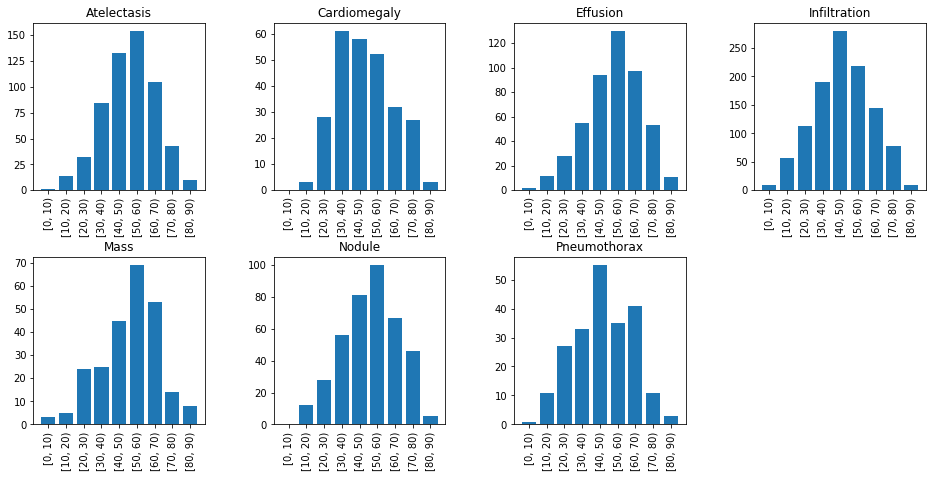

In [11]:
# Plots bar graphs that show number of occurrences of each diagnoses in each age group.
plt.figure(figsize=(16,16))
plt.subplots_adjust(hspace=0.4, wspace=0.4)

plot_num = 1
for label in all_labels:
    ax = plt.subplot(4,4, plot_num)
    ax.bar(np.arange(len(age_groups)) + 1.5, age_groups[label])
    ax.set_xticks(np.arange(len(age_groups)) + 1.5)
    _ = ax.set_xticklabels(age_groups.index, rotation = 90)
    ax.set_title(label)
    plot_num += 1

'''
  Note the correlation with age.
  We think the drop off with occurrence after 60 is
  related to the fact that the population size reduces
  with age, so there should be fewer cases.
'''

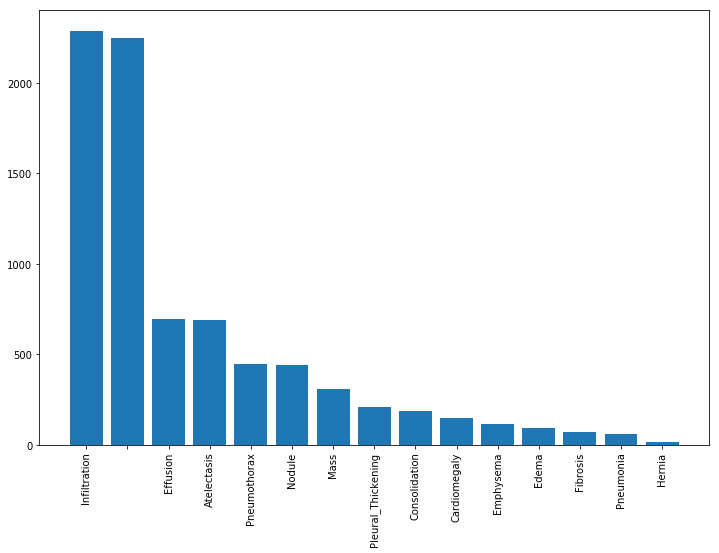

In [80]:
# counts = xray_labels_df['Finding Labels'].value_counts().tolist()
# sample_weights = [count + 4e-2 for count in counts]
# print(sample_weights)
# sample_weights_sum = sum(sample_weights)
# #sample_weights = xray_labels_df['Finding Labels'].value_counts().tolist() + 4e-2
# sample_weights = [sample_weight / sample_weights_sum for sample_weight in sample_weights]

sample_weights = xray_labels_df['Finding Labels'].map(lambda x: len(x.split('|')) if len(x)>0 else 0).values + 4e-2
sample_weights /= sample_weights.sum()

xray_labels_df = xray_labels_df.sample(8000, weights = sample_weights)
label_counts = xray_labels_df['Finding Labels'].value_counts()[:15]
fig, ax1 = plt.subplots(1,1,figsize = (12,8))
ax1.bar(np.arange(len(label_counts)) + 0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5) 
_ = ax1.set_xticklabels(label_counts.index, rotation = 90)

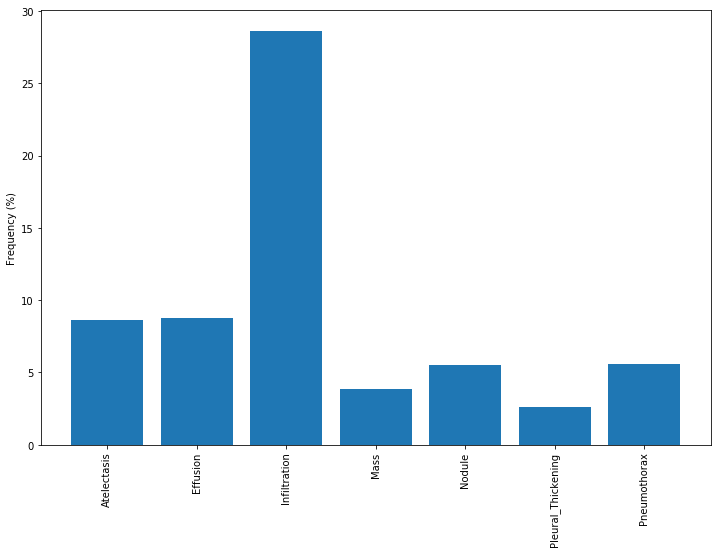

In [13]:
# Distribution of disease findings remaining
label_counts = 100*np.mean(xray_labels_df[all_labels].values, 0)
fig, ax1 = plt.subplots(1,1, figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
ax1.set_xticklabels(all_labels, rotation = 90)
_ = ax1.set_ylabel('Frequency (%)')

Preparing Training Data:
----------------------

In [14]:
# Creates disease vector with values 0 or 1 that model will predict.
xray_labels_df['disease_vec'] = xray_labels_df.apply(lambda x: [x[all_labels].values], 1).map(lambda x: x[0])


In [15]:
# Splitting data into training and validation sets.
from sklearn.model_selection import train_test_split
training_df, validation_df = train_test_split(xray_labels_df, 
                                              test_size = 0.25, 
                                              random_state = 2018,
                                              stratify = xray_labels_df['Finding Labels'].map(lambda x: x[:4]))

print('train', training_df.shape[0], 'validation', validation_df.shape[0])

train 6000 validation 2000


In [16]:
from keras.preprocessing.image import ImageDataGenerator
IMG_SIZE = (256, 256)
core_idg = ImageDataGenerator(samplewise_center=True,
                              samplewise_std_normalization=True,
                              horizontal_flip=True,
                              vertical_flip=True,
                              height_shift_range=0.05,
                              width_shift_range=0.1,
                              rotation_range=5,
                              shear_range=0.1,
                              fill_mode='reflect',
                              zoom_range=0.15)

/anaconda3/envs/csc665/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [17]:
def flow_from_dataframe(img_data_gen, in_df, path_col, y_col, **dflow_args):
    base_dir = os.path.dirname(in_df[path_col].values[0])
    
    df_gen = img_data_gen.flow_from_directory(base_dir, class_mode='sparse', **dflow_args)
    df_gen.filenames = in_df[path_col].values
    df_gen.classes = np.stack(in_df[y_col].values)
    df_gen.samples = in_df.shape[0]
    df_gen.n = in_df.shape[0]
    df_gen._set_index_array()
    df_gen.directory = ''
    print('Reinserting dataframe: {} images'.format(in_df.shape[0]))
    
    # df_gen is an iterator that yields a tuple (X,Y). 
    # X = batch of images, and Y = corresponding labels.
    return df_gen
    

In [18]:
# Generates training and validation data to be used by models.
training_gen = flow_from_dataframe(core_idg, training_df, path_col='path', y_col='disease_vec',target_size = IMG_SIZE, color_mode ='grayscale', batch_size = 32)
validation_gen = flow_from_dataframe(core_idg, validation_df, path_col='path', y_col='disease_vec',target_size = IMG_SIZE, color_mode ='grayscale', batch_size = 256)

test_X, test_Y = next(flow_from_dataframe(core_idg, validation_df, path_col ='path', y_col ='disease_vec', target_size = IMG_SIZE, color_mode = 'grayscale', batch_size = 1024))



Found 0 images belonging to 0 classes.
Reinserting dataframe: 6000 images
Found 0 images belonging to 0 classes.
Reinserting dataframe: 2000 images
Found 0 images belonging to 0 classes.
Reinserting dataframe: 2000 images


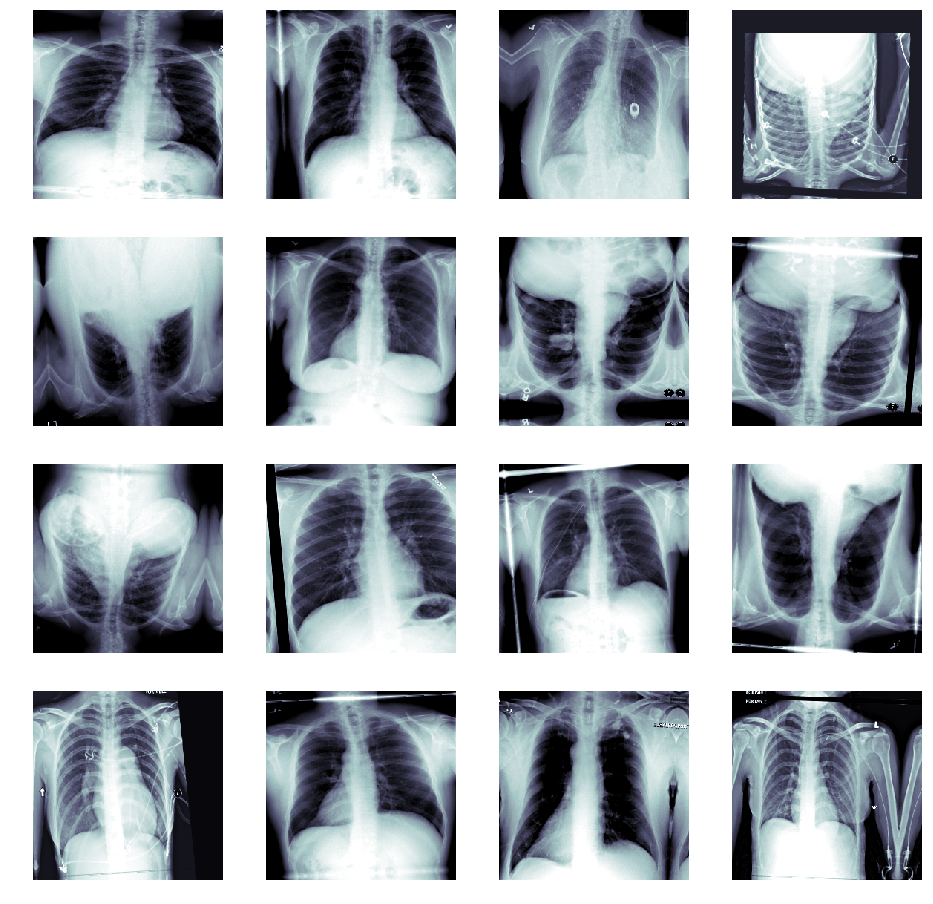

In [29]:
# Visualizing images and their corresponding diagnoses.
# t_x = images, t_y = labels
t_x, t_y = next(training_gen)
fig, m_axs = plt.subplots(4,4,figsize=(16,16))
for(c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap='bone', vmin=-1.5, vmax=1.5)
    c_ax.set_title(', '.join([n_class for n_class, n_score in zip(all_labels, c_y) if n_score > 0.5]))
    c_ax.axis('off')

Model Creation:
--------------

In [20]:
from keras.applications.mobilenet import MobileNet
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from keras.models import Sequential
import tensorflow as tf

base_mobilenet_model = MobileNet(input_shape = t_x.shape[1:],
                                 include_top = False, weights = None)

multi_disease_model = Sequential()
multi_disease_model.add(base_mobilenet_model)
multi_disease_model.add(GlobalAveragePooling2D())
multi_disease_model.add(Dropout(0.5))
multi_disease_model.add(Dense(512))
multi_disease_model.add(Dropout(0.5))
multi_disease_model.add(Dense(len(all_labels), activation = 'sigmoid'))
multi_disease_model.compile(optimizer = 'adam', loss ='binary_crossentropy',
                            metrics = ['binary_accuracy', 'mae'])
multi_disease_model.summary()

multi_disease_model.load_weights('xray_class_weights_sigmoid_256x256.best.hdf5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_256 (Model)   (None, 8, 8, 1024)        3228288   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 7)                 3591      
Total params: 3,756,679
Trainable params: 3,734,791
Non-trainable params: 21,888
_____________________________________________________________

In [61]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

weight_path = "{}_weights_sigmoid_256x256.best.hdf5".format("xray_class")

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=3)
callbacks_list = [checkpoint, early]

In [62]:
multi_disease_model.fit_generator(training_gen, 
                                  steps_per_epoch=100,
                                  validation_data = (test_X, test_Y), 
                                  epochs = 1, 
                                  callbacks = callbacks_list)

Epoch 1/1
100/100 [==============================] - 2611s 26s/step - loss: 0.3904 - binary_accuracy: 0.8945 - mean_absolute_error: 0.1531 - val_loss: 0.3234 - val_binary_accuracy: 0.9079 - val_mean_absolute_error: 0.1628

Epoch 00001: val_loss improved from inf to 0.32337, saving model to xray_class_weights_sigmoid_256x256.best.hdf5


In [21]:
for c_label, s_count in zip(all_labels, 100*np.mean(test_Y,0)):
    print('%s: %2.2f%%' % (c_label, s_count))

Atelectasis: 8.50%
Effusion: 8.89%
Infiltration: 30.18%
Mass: 4.10%
Nodule: 5.27%
Pleural_Thickening: 2.15%
Pneumothorax: 5.27%


In [22]:
pred_Y = multi_disease_model.predict(test_X, batch_size = 32, verbose = True)

1024/1024 [==============================] - 213s 208ms/step


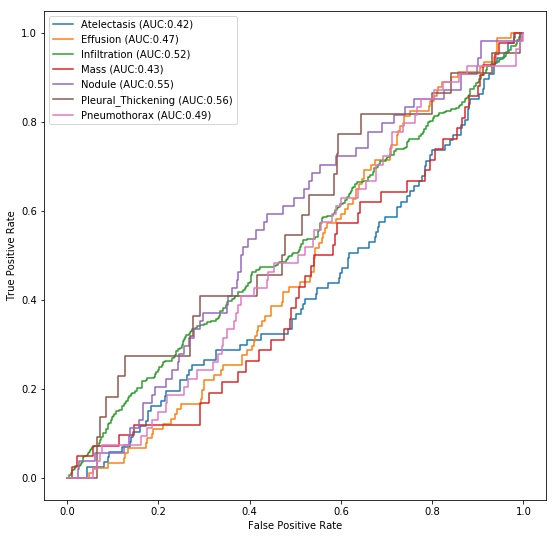

In [23]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(all_labels):
    fpr, tpr, thresholds = roc_curve(test_Y[:,idx].astype(int), pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig('barely_trained_net_256x256.png')

In [32]:
# Try removing data from dataframe that has multiple diagnoses.
# Train model, record results for Alvin's presentation
# Mess around with creating own CNN. Maybe model after DeepMind's CNN used for Q-Learning?

multi_disease_model.fit_generator(training_gen, 
                                  steps_per_epoch = 100,
                                  validation_data =  (test_X, test_Y), 
                                  epochs = 5, 
                                  callbacks = callbacks_list)

Epoch 1/5
100/100 [==============================] - 501s 5s/step - loss: 0.3545 - binary_accuracy: 0.8795 - mean_absolute_error: 0.1759 - val_loss: 0.5387 - val_binary_accuracy: 0.8880 - val_mean_absolute_error: 0.1399

Epoch 00001: val_loss did not improve
Epoch 2/5
100/100 [==============================] - 501s 5s/step - loss: 0.3186 - binary_accuracy: 0.8838 - mean_absolute_error: 0.1744 - val_loss: 0.3070 - val_binary_accuracy: 0.8844 - val_mean_absolute_error: 0.1653

Epoch 00002: val_loss improved from 0.48010 to 0.30700, saving model to xray_class_weights.best.hdf5
Epoch 3/5
100/100 [==============================] - 4067s 41s/step - loss: 0.3067 - binary_accuracy: 0.8848 - mean_absolute_error: 0.1749 - val_loss: 0.3051 - val_binary_accuracy: 0.8844 - val_mean_absolute_error: 0.1643

Epoch 00003: val_loss improved from 0.30700 to 0.30506, saving model to xray_class_weights.best.hdf5
Epoch 4/5
100/100 [==============================] - 510s 5s/step - loss: 0.2971 - binary_accur

In [33]:
multi_disease_model.load_weights(weight_path)

In [34]:
pred_Y = multi_disease_model.predict(test_X, batch_size = 32, verbose = True)


1024/1024 [==============================] - 54s 52ms/step


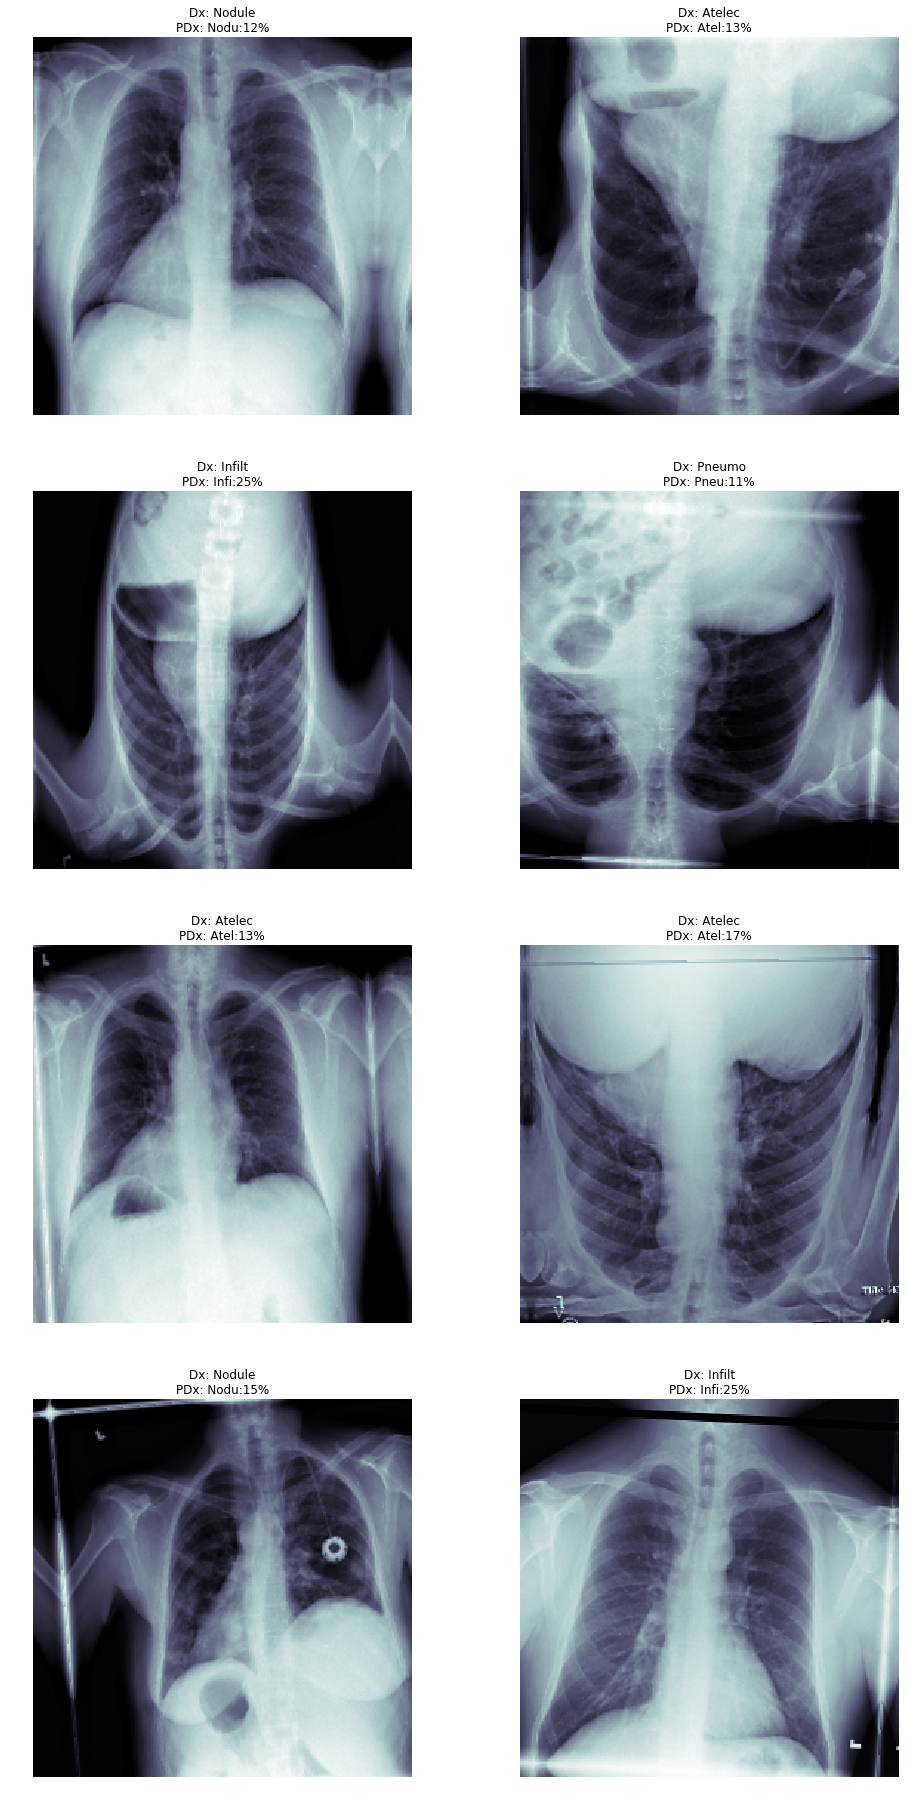

In [26]:
sickest_idx = np.argsort(np.sum(test_Y, 1)<1)
fig, m_axs = plt.subplots(4, 2, figsize = (16, 32))
for (idx, c_ax) in zip(sickest_idx, m_axs.flatten()):
    c_ax.imshow(test_X[idx, :,:,0], cmap = 'bone')
    stat_str = [n_class[:6] for n_class, n_score in zip(all_labels, 
                                                                  test_Y[idx]) 
                             if n_score>0.5]
    pred_str = ['%s:%2.0f%%' % (n_class[:4], p_score*100)  for n_class, n_score, p_score in zip(all_labels, 
                                                                  test_Y[idx], pred_Y[idx]) 
                             if (n_score>0.5) or (p_score>0.5)]
    c_ax.set_title('Dx: '+', '.join(stat_str)+'\nPDx: '+', '.join(pred_str))
    c_ax.axis('off')
fig.savefig('barely_trained_img_predictions_256x256.png')

ReLU Model:
----------


In [42]:
from keras.applications.mobilenet import MobileNet
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from keras.models import Sequential
import tensorflow as tf

base_mobilenet_model_relu = MobileNet(input_shape = t_x.shape[1:],
                                 include_top = False, weights = None)

multi_disease_model_relu = Sequential()
multi_disease_model_relu.add(base_mobilenet_model_relu)
multi_disease_model_relu.add(GlobalAveragePooling2D())
multi_disease_model_relu.add(Dropout(0.5))
multi_disease_model_relu.add(Dense(512))
multi_disease_model_relu.add(Dropout(0.5))
multi_disease_model_relu.add(Dense(len(all_labels), activation = 'relu'))
multi_disease_model_relu.compile(optimizer = 'adam', loss ='binary_crossentropy',
                            metrics = ['binary_accuracy', 'mae'])
multi_disease_model_relu.summary()

multi_disease_model_relu.load_weights('xray_class_weights_relu.best.hdf5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_128 (Model)   (None, 4, 4, 1024)        3228288   
_________________________________________________________________
global_average_pooling2d_4 ( (None, 1024)              0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_8 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 7)                 3591      
Total params: 3,756,679
Trainable params: 3,734,791
Non-trainable params: 21,888
_____________________________________________________________

In [45]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

weight_path = "{}_weights_relu.best.hdf5".format("xray_class")

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=3)
callbacks_list = [checkpoint, early]

In [44]:
multi_disease_model_relu.fit_generator(training_gen, 
                                       steps_per_epoch=100,
                                       validation_data = (test_X, test_Y), 
                                       epochs = 1, 
                                       callbacks = callbacks_list)

Epoch 1/1
100/100 [==============================] - 525s 5s/step - loss: 1.4751 - binary_accuracy: 0.9072 - mean_absolute_error: 0.0952 - val_loss: 1.4639 - val_binary_accuracy: 0.9092 - val_mean_absolute_error: 0.0908

Epoch 00001: val_loss improved from inf to 1.46385, saving model to xray_class_weights_relu.best.hdf5


In [46]:
multi_disease_model_relu.fit_generator(training_gen, 
                                       steps_per_epoch = 100,
                                       validation_data =  (test_X, test_Y), 
                                       epochs = 5, 
                                       callbacks = callbacks_list)

Epoch 1/5
100/100 [==============================] - 520s 5s/step - loss: 1.4478 - binary_accuracy: 0.9102 - mean_absolute_error: 0.0898 - val_loss: 1.4639 - val_binary_accuracy: 0.9092 - val_mean_absolute_error: 0.0908

Epoch 00001: val_loss improved from inf to 1.46385, saving model to xray_class_weights_relu.best.hdf5
Epoch 2/5
100/100 [==============================] - 527s 5s/step - loss: 1.4729 - binary_accuracy: 0.9086 - mean_absolute_error: 0.0914 - val_loss: 1.4639 - val_binary_accuracy: 0.9092 - val_mean_absolute_error: 0.0908

Epoch 00002: val_loss did not improve
Epoch 3/5
100/100 [==============================] - 526s 5s/step - loss: 1.4729 - binary_accuracy: 0.9086 - mean_absolute_error: 0.0914 - val_loss: 1.4639 - val_binary_accuracy: 0.9092 - val_mean_absolute_error: 0.0908

Epoch 00003: val_loss did not improve
Epoch 4/5
100/100 [==============================] - 524s 5s/step - loss: 1.4492 - binary_accuracy: 0.9101 - mean_absolute_error: 0.0899 - val_loss: 1.4639 - v

In [48]:
pred_Y_relu = multi_disease_model_relu.predict(test_X, batch_size = 32, verbose = True)

1024/1024 [==============================] - 62s 60ms/step


In [53]:
score = multi_disease_model_relu.evaluate(test_X, test_Y, verbose=0)
print("Accuracy: " + str(round(score[1]*100,2)) + "%")


SyntaxError: invalid syntax (<ipython-input-53-c4dba18d3516>, line 1)